In [1]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 800)
from collections import Counter
import numpy as np

In [2]:
df = pd.read_csv('SCADA_data.csv')
df['Inverter avg. temp'] = df[['CS101 : Sys 1 inverter 1 cabinet temp.',
                          'CS101 : Sys 1 inverter 2 cabinet temp.', 
                          'CS101 : Sys 1 inverter 3 cabinet temp.', 
                          'CS101 : Sys 1 inverter 4 cabinet temp.', 
                          'CS101 : Sys 1 inverter 5 cabinet temp.', 
                          'CS101 : Sys 1 inverter 6 cabinet temp.', 
                          'CS101 : Sys 1 inverter 7 cabinet temp.',
                          'CS101 : Sys 2 inverter 1 cabinet temp.', 
                          'CS101 : Sys 2 inverter 2 cabinet temp.',  
                          'CS101 : Sys 2 inverter 3 cabinet temp.',
                          'CS101 : Sys 2 inverter 4 cabinet temp.']].mean(axis=1)
df['Inverter std. temp'] = df[['CS101 : Sys 1 inverter 1 cabinet temp.',
                         'CS101 : Sys 1 inverter 2 cabinet temp.', 
                         'CS101 : Sys 1 inverter 3 cabinet temp.', 
                         'CS101 : Sys 1 inverter 4 cabinet temp.', 
                         'CS101 : Sys 1 inverter 5 cabinet temp.', 
                         'CS101 : Sys 1 inverter 6 cabinet temp.', 
                         'CS101 : Sys 1 inverter 7 cabinet temp.',
                         'CS101 : Sys 2 inverter 1 cabinet temp.', 
                         'CS101 : Sys 2 inverter 2 cabinet temp.',  
                         'CS101 : Sys 2 inverter 3 cabinet temp.',
                         'CS101 : Sys 2 inverter 4 cabinet temp.']].std(axis=1)

In [3]:
df['Time'] = pd.to_datetime(df['Time'], dayfirst=True, errors='coerce')
df.sort_values(by='Time', axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
# df['Fault'] = df['Error']
# df.drop('Error', inplace=True, axis=1)
df.rename(columns={"Error": "Fault"}, inplace=True)

In [5]:
status_data_wec = pd.read_csv('status_data_wec.csv')
af_corr_time_wec_s = status_data_wec.loc[(status_data_wec['Main Status']==62)|(status_data_wec['Main Status']==80)|
                                         (status_data_wec['Main Status']==228)|(status_data_wec['Main Status']==60)|
                                         (status_data_wec['Main Status']==9),
                                         'Time']

In [6]:
af_corr_time_wec_s = pd.to_datetime(af_corr_time_wec_s)
af_corr_time_wes = af_corr_time_wec_s.round('10min')

In [7]:
df['Fault'] = [0] * len(df)
for i, d in enumerate(df['Time']):
    if d in af_corr_time_wes.values:
        df['Fault'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
nf_times = []
rul = []
for i, d in enumerate(df['Fault']):
    nf_times.append(df['Time'][i])
    if d == 1:
        for j in nf_times:
            rul.append(df['Time'][i] - j)
        nf_times = []    

In [9]:
rul_seconds = [x.total_seconds() for x in rul]
rul_hours = [x//3600 for x in rul_seconds]
rul_days = [x.days for x in rul]

df_trimmed = df.head(len(rul))

In [10]:
df_trimmed['RUL'] = rul_days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
cols_to_drop = ['Fault',
                'CS101 : Sys 1 inverter 1 cabinet temp.',
                'CS101 : Sys 1 inverter 2 cabinet temp.', 
                'CS101 : Sys 1 inverter 3 cabinet temp.', 
                'CS101 : Sys 1 inverter 4 cabinet temp.', 
                'CS101 : Sys 1 inverter 5 cabinet temp.', 
                'CS101 : Sys 1 inverter 6 cabinet temp.', 
                'CS101 : Sys 1 inverter 7 cabinet temp.',
                'CS101 : Sys 2 inverter 1 cabinet temp.', 
                'CS101 : Sys 2 inverter 2 cabinet temp.',  
                'CS101 : Sys 2 inverter 3 cabinet temp.',
                'CS101 : Sys 2 inverter 4 cabinet temp.']

for i in cols_to_drop:
  if i in list(df):
    df_trimmed.drop(i, axis=1, inplace=True)                

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# from datetime import date, timedelta   

# df_trimmed = df_trimmed.head(39293)
# week_prior = df_trimmed['Time'].iloc[-1] - timedelta(weeks=1)
# df_train = df_trimmed[df_trimmed['Time']<=week_prior]
# df_test = df_trimmed[df_trimmed['Time']>week_prior]

df_trimmed.set_index('Time', inplace=True)

In [13]:
timesteps = 5

df_trimmed = df_trimmed.head(39298)
df = df_trimmed.copy()
features = df.columns.tolist()

df_list = [df[features].shift(shift_val) if (shift_val == 0) 
                                else df[features].shift(-shift_val).add_suffix(f'_{shift_val}') 
                                for shift_val in range(0,timesteps)]

In [14]:
df_concat = pd.concat(df_list, axis=1, sort=False)
df_concat = df_concat.iloc[:-timesteps,:]

In [15]:
from sklearn.model_selection import train_test_split

target = 'RUL'
x_train, x_test, y_train, y_test = train_test_split(df_concat, 
                                                    df[target].iloc[:-timesteps], 
                                                    test_size = 0.02642894598,
                                                    random_state=10, shuffle=False) 

In [16]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

xgbr = xgb.XGBRegressor()

param_grid = {
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [30, 40, 50, 60, 70, 90, 80, 100],
        'objective': ['reg:squarederror']
        }

rf_xgb = RandomizedSearchCV(xgbr, 
                            param_grid,
                            cv = 5,
                            n_jobs=1)

rf_xgb.fit(x_train, y_train)
  
# Predict the model
y_pred = rf_xgb.predict(x_test)
  
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))
print("RMSE : % f" %(rmse))

RMSE :  0.018534


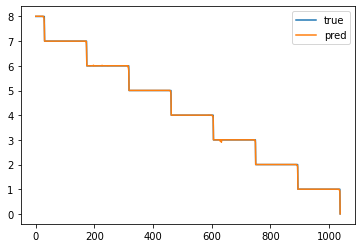

In [17]:
df_out = pd.DataFrame()
df_out['true'] = np.ravel(y_test.values)
df_out['pred'] = y_pred

df_out.plot()

In [18]:
import pickle


pickle.dump(rf_xgb, open("xgb_reg.pkl", "wb"))

